<a href="https://colab.research.google.com/github/AadityaAdh/virtual_try_on-VTON-/blob/main/U2net_training_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
def load_mask(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    gray_img = tf.image.rgb_to_grayscale(img)
    return gray_img

In [5]:
train_images=tf.data.Dataset.list_files('/content/drive/MyDrive/data/images/*.jpg',shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (128,128)))
train_images = train_images.map(lambda x: x/255)

In [6]:
len(train_images)

55

In [7]:
train_mask=tf.data.Dataset.list_files('/content/drive/MyDrive/data/mask/*.jpg',shuffle=False)
train_mask = train_mask.map(load_mask)
train_mask = train_mask.map(lambda x: tf.image.resize(x, (128,128)))
train_mask = train_mask.map(lambda x: x/255)

In [8]:
len(train_mask)

55

In [9]:
for ele in train_mask.take(1):
  print(ele.shape)

(128, 128, 1)


In [10]:
train = tf.data.Dataset.zip((train_images, train_mask))
train = train.shuffle(500)
train = train.batch(2)
train = train.prefetch(1)

In [11]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [12]:
def conv_block(inputs, num_filters):
  x = Conv2D(num_filters, 3, padding="same") (inputs)
  x=BatchNormalization()(x)
  x = Activation ("relu") (x)

  x = Conv2D(num_filters, 3, padding="same") (x)
  x = BatchNormalization () (x)
  x = Activation ("relu") (x)
  return x

In [13]:
def encoder_block(inputs,num_filters):
  x=conv_block(inputs,num_filters)
  p=MaxPool2D((2,2))(x)
  return x,p


In [14]:
def decoder_block(inputs, skip, num_filters) :
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same") (inputs)
  x = Concatenate() ([x, skip])
  x = conv_block(x, num_filters)
  return x

In [15]:
def build_unet (input_shape) :
  inputs = Input (input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024)


  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2,128)
  d4 = decoder_block(d3, s1, 64)
  outputs = Conv2D(1, 1, padding="same", activation="sigmoid" ) (d4)
  model = Model (inputs, outputs, name="UNET" )
  return model

In [16]:
my_m=build_unet((128,128,3))

In [17]:
my_m.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 64)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 64)   │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 64, 64, 128)    │            512 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 64, 64, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 64, 64, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 31,055,297 (118.47 MB)

 Trainable params: 31,043,521 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [18]:
my_m.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(0.0001),metrics=["acc"])

In [19]:
my_m.fit(train,epochs=20,verbose=1)

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 79s 680ms/step - acc: 0.7197 - loss: 0.5864
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - acc: 0.9073 - loss: 0.2742
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9303 - loss: 0.1950
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.9323 - loss: 0.1660
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9378 - loss: 0.1559
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9440 - loss: 0.1326
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - acc: 0.9502 - loss: 0.1150
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - acc: 0.9560 - loss: 0.0969
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9596 - loss: 0.0917
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9528 - loss: 0.0979
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - acc: 0.9587 - loss: 0.0865
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - acc: 0.9573 - loss: 0.0822
Epoch 13/20
28/28 ━━━━━━━━━━━━━━━━━

In [20]:
# Define the path where you want to save the model in Google Drive
model_save_path = '/content/drive/My Drive/umodelone.h5'

# Save the model
my_m.save(model_save_path)


In [37]:
x=train_images.take(1)



In [38]:
x=x.batch(1)

In [39]:
predi=my_m.predict(x)
predi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[[[0.0939381 ],
         [0.07563458],
         [0.0615193 ],
         ...,
         [0.06748588],
         [0.08239889],
         [0.12384725]],

        [[0.0752109 ],
         [0.05041379],
         [0.04614524],
         ...,
         [0.05103796],
         [0.05774288],
         [0.06438088]],

        [[0.0559275 ],
         [0.05410866],
         [0.04922932],
         ...,
         [0.04431668],
         [0.0507498 ],
         [0.057621  ]],

        ...,

        [[0.06568279],
         [0.04907211],
         [0.04768315],
         ...,
         [0.05919559],
         [0.05912475],
         [0.05600373]],

        [[0.0652386 ],
         [0.04843394],
         [0.04652718],
         ...,
         [0.05688988],
         [0.06588664],
         [0.06896023]],

        [[0.12164442],
         [0.11069714],
         [0.08560482],
         ...,
         [0.10082639],
         [0.10667937],
         [0.12838499]]]], dtype=float32)

In [40]:
predi.shape

(1, 128, 128, 1)

In [41]:
predi=np.reshape(predi,(128,128,1))

In [42]:
predi.shape

(128, 128, 1)

In [43]:
predi=predi*225

In [44]:
predi

array([[[21.136072 ],
        [17.017782 ],
        [13.841843 ],
        ...,
        [15.184324 ],
        [18.539751 ],
        [27.865631 ]],

       [[16.922453 ],
        [11.343103 ],
        [10.382679 ],
        ...,
        [11.483541 ],
        [12.992148 ],
        [14.485697 ]],

       [[12.583687 ],
        [12.174448 ],
        [11.076597 ],
        ...,
        [ 9.971252 ],
        [11.418704 ],
        [12.964725 ]],

       ...,

       [[14.778628 ],
        [11.0412245],
        [10.728709 ],
        ...,
        [13.319008 ],
        [13.303068 ],
        [12.60084  ]],

       [[14.678684 ],
        [10.897635 ],
        [10.4686165],
        ...,
        [12.800222 ],
        [14.824493 ],
        [15.516053 ]],

       [[27.369995 ],
        [24.906857 ],
        [19.261086 ],
        ...,
        [22.685938 ],
        [24.002857 ],
        [28.886623 ]]], dtype=float32)

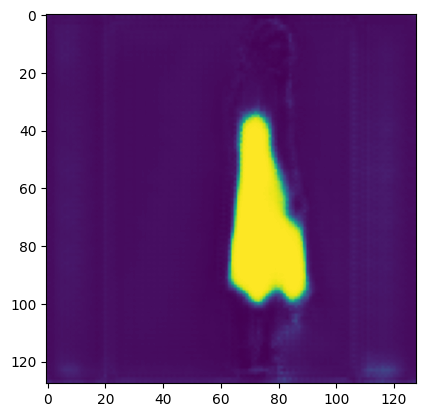

In [45]:
plt.imshow(predi)

In [46]:
x

<_BatchDataset element_spec=TensorSpec(shape=(None, 128, 128, None), dtype=tf.float32, name=None)>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


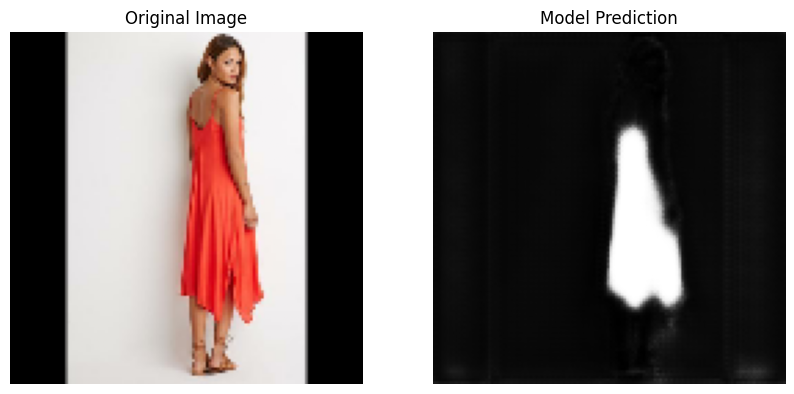

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


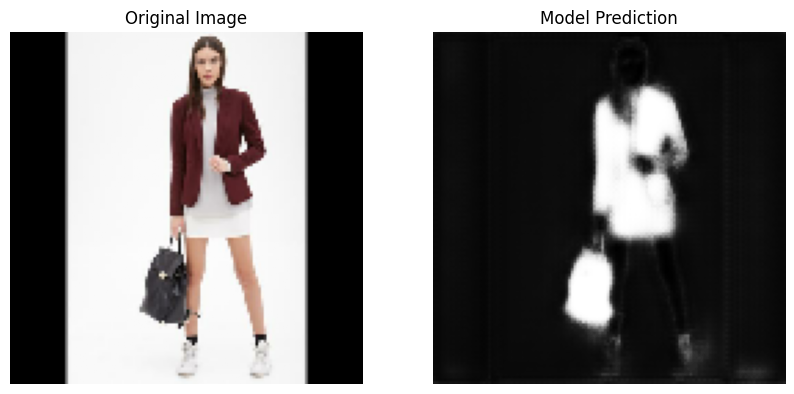

In [56]:
for elements in train_images.take(2):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(elements.numpy())
    plt.title("Original Image")
    plt.axis('off')
    x = np.reshape(elements, (1, 128, 128, 3))
    predi = my_m.predict(x)
    predi = np.reshape(predi, (128, 128, 1))
    plt.subplot(1, 2, 2)
    plt.imshow(predi, cmap='gray')
    plt.title("Model Prediction")
    plt.axis('off')
    plt.show()
